In [1]:
# I load the needed libraries
library(dplyr)
library(scales)
library(GoFKernel)

library(mvtnorm)
library(gplots)
library(coda)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [2]:
# Now I can change the function to generate the new data in the MCMC

# Then I create the function to extract the random number
generation_s = function (x0, cov) {

    # I use the library method to generate the new point
    new_value = rmvnorm(1, mean = x0, sigma = cov, method = c("eigen", "svd", "chol"), pre0.9_9994 = FALSE, checkSymmetry = FALSE)

    return(new_value)
}

# And the one to check the value of the quantiles
evaluate_Q = function(x0, cov, point) {

    # For the case of the normal distribution
    sx = dmvnorm(point, mean = x0, sigma = cov, log = FALSE)
    dx = dmvnorm(x0, mean = point, sigma = cov, log = FALSE)

    return(sx/dx)
}

# This function is ment to return the sequence of the samples for a determined function
random_steps = function (func_wanted, theta_init, n_samples, sigma, print_accept=FALSE) {

    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    dimensions = length(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = length(theta_init) + 1)

    # For statistical purposes
    accepted = 0

    # Evolution loop
    for (n in 1:n_samples) {

        guessed_theta = current_theta

        # I then can loop on the dimensions of the distribution to allpy the gibbs sampling
        for (dim in 1:dimensions) {

            # Take a guessed new theta (s in the slides) and evaluate its probability
            guessed_theta[dim] = generation_s(current_theta, sigma)[dim]
            guessed_function = func_wanted(guessed_theta)

            # Acceptance conditions
            Q_ratio = evaluate_Q(current_theta, sigma, guessed_theta)
            rho = guessed_function/current_function * Q_ratio
            # cat(guessed_theta, guessed_function, Q_ratio, rho)

            # And then update the general conditions
            if (rho > runif(1)) {
                current_theta = guessed_theta
                current_function = guessed_function
                accepted = accepted + 1
            } # else they remain unchanged and then loaded direcctly in the solutions vector

            # Saving the generated samples because R doesn't accept two elements in returns
            samples[n,] = unlist(c(current_function, current_theta))
        
        }

    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/(n_samples*dimensions)*100, 5), '%\n')
    }

    return(samples)
}


In [3]:
# Function to sampled from: n-dim gaussian with chosen sigmas and centers
posterior_g_inhom = function (theta) {

    sigmas = c(1:length(theta))
    centers = c(seq(length(theta), 1))

    product = 1
    for (i in 1:length(theta)) {
        product = product * exp(-(theta[i] - centers[i])**2/sigmas[i]**2)
    }

    return (product)

}

# The initial parameters are:
init = c(1, 2, 3)
std = diag(1, 3)
burn_in = 0
N = as.integer(1e5) + burn_in

# Evaluate then the MCMC
mcmc_g = random_steps(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N, sigma = std, print_accept=TRUE)

# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[burn_in:N, ]


Acceptance rate =  57.27567 %


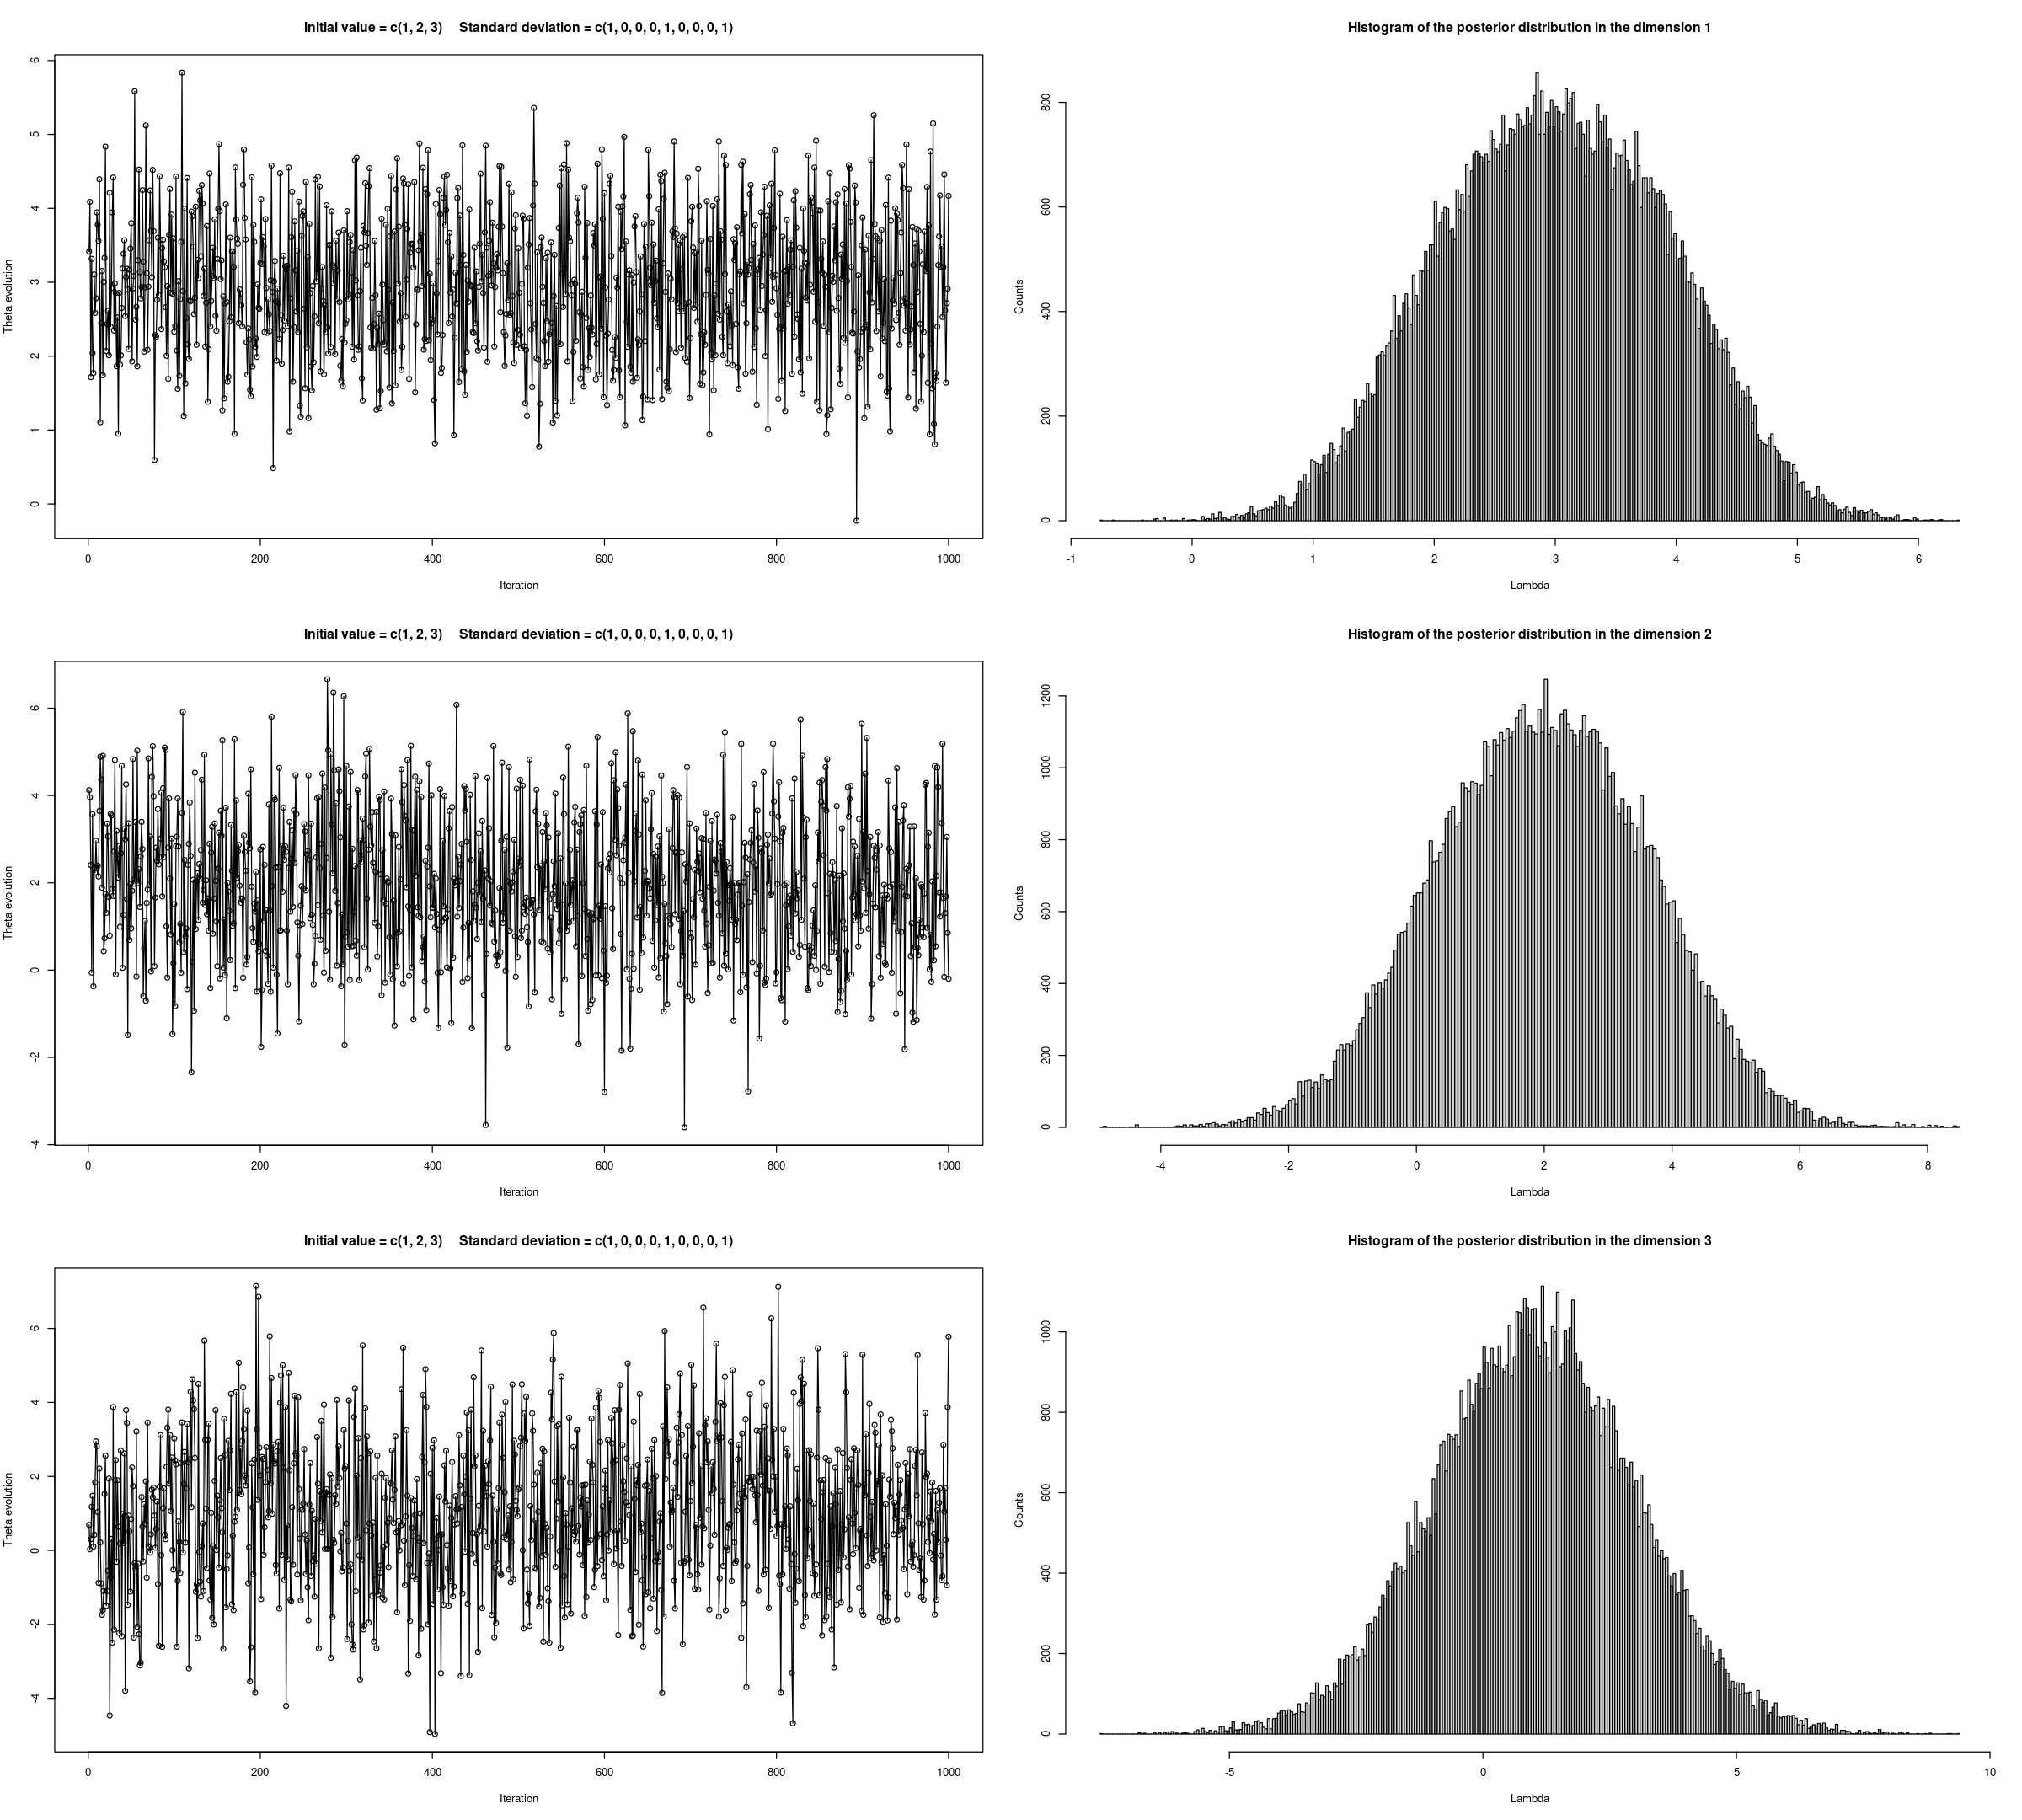

In [4]:
# Printing then the evolution of the chain and the resulting distribution
lungh = as.integer(length(mcmc_g[1,]))
step = 1e2

# Plotting every dimension of the plot
par(mfrow=c(lungh-1, 2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    plot_g = mcmc_g[seq(0, length(mcmc_g[,1]), step), dim]
    plot(1:length(plot_g), plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution', 
        main = paste0('Initial value = ', list(init), '     Standard deviation = ', list(std)))
    hist(mcmc_g[,dim], breaks = as.integer(sqrt(length(mcmc_g[,1]))), xlab = 'Lambda', ylab = 'Counts',
        main = paste('Histogram of the posterior distribution in the dimension', dim-1))
}


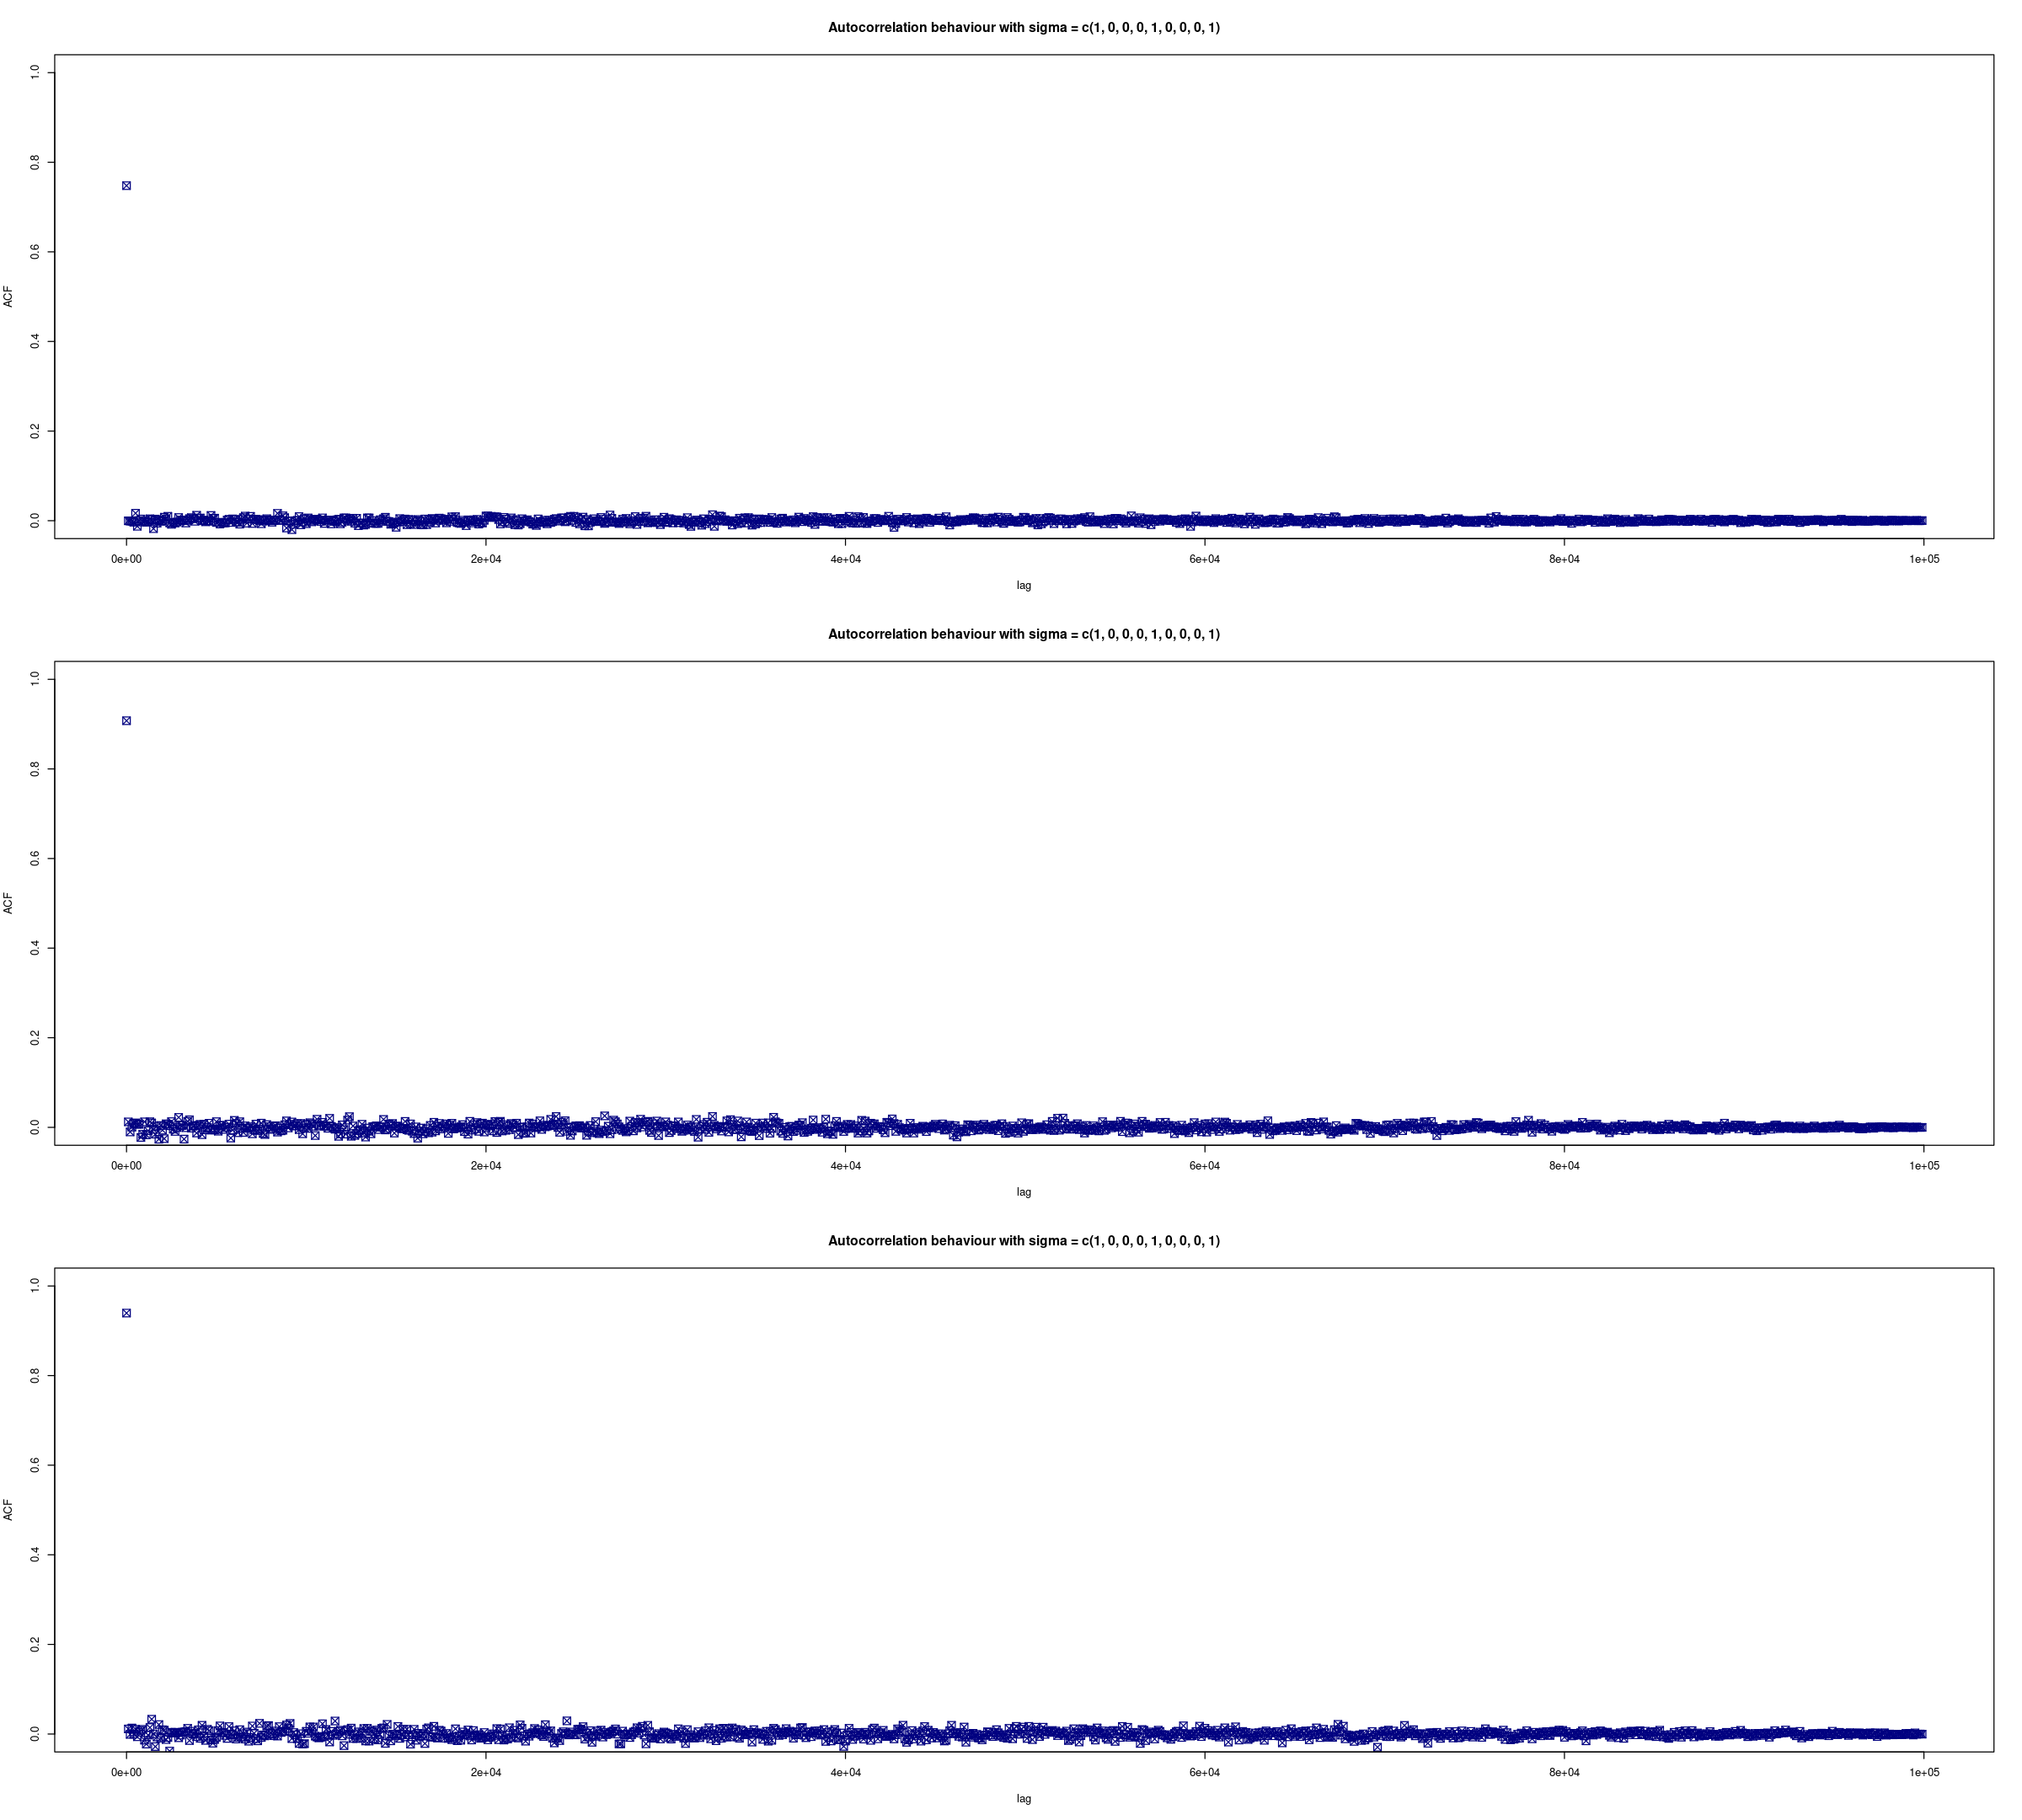

In [5]:
lungh = as.integer(length(mcmc_g[1,]))
step = 1e2

par(mfrow=c(lungh-1, 1), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    # I ensure that this is now a MCMC
    g_chain = as.mcmc(mcmc_g[,dim])

    # Then I check the autocorrelation using CODA
    lags = seq(1,1e5,100)
    auto_g = autocorr(g_chain, lags=lags)

    # And finally I plot the autocorrelation evolution:
    plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", list(std)))
}
